In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

### ITO stochastic differential equation

Consider a one dimensional ITO Stochastic Differential Equation (SDE)

$$
dx(t) = f(x(t),t) dt + \sigma(x(t),t) dW_t \, ,
$$

with $f,\sigma : \mathbb{R} \rightarrow \mathbb{R}$ and $W(t)$ is a Wiener process.

Consider a time interval $[0,\tau]$, and a discretization in $N$ equal subintervals $\Delta t = t_{k+1}-t_k$, with $t_k=0$ and $t_{N}=\tau$.

The SDE is discretized, according to ITO, as

$$
x_{k+1} = x_k + f(x_k,t_k) \Delta t + \sigma(x_k,t_k) [W_{k+1} - W_k] \, .
$$

Notation: $x_{k+1} = x(t_{t_k+1}$ and $W_{k+1} = W(t_{k+1})$.

Note that $\sigma(x(t),t)$ is estimated at time $t_k$, i.e. at the left point of the inteval $[t_k,t_{k+1}]$ as required by Ito.

The increments $W(t+\Delta t) - W(t)$ are drawn from a Gaussian distribution with mean 0 and variance $\Delta t$:

$$
W(t+\Delta t) - W(t) \sim \mathcal{N}(0,\Delta t) \, ,
$$

then the increments $W(t+\Delta t) - W(t)$ can be approximated as

$$
W(t+\Delta t) - W(t) \sim \mathcal{N}(0,1) \sqrt{\Delta t} \sim \eta \sqrt{\Delta t} \,,
$$

with $\eta$ random number drawn from a standard Gaussian distribution with mean 0 and variance 1.

This integration scheme is called Euler-Maruyama integration scheme.

### Stratonovich stochastic differential equation

The Stratonovich SDE equivalent to the ITO SDE is 

$$
dx(t) = f(x(t),t) dt - \frac{1}{2} \frac{\partial \sigma}{\partial x}\sigma(x(t),t)dt + \sigma(x(t),t) \circ dW_t \, ,
$$

which can be discretized as

$$
x_{k+1} = x_k + f(x_k,t_k) \Delta t - \frac{1}{2} \frac{\partial \sigma}{\partial x}\sigma\left(\frac{x_{k+1} + x_k}{2},\frac{t_{k+1} + t_k}{2}\right) \Delta t + \sigma(x_k,t_k) [W_{k+1} - W_k] \, .
$$

This equation cannot be directly solved as the term $x_{k + 1}$ appears on both the sides.

Here, we use a predictor-corrector method:
1. We first obtain the an approximation of $\tilde{x}_{k+1}$ with the Euler-Maruyama integration scheme (prediction)

$$
\tilde{x}_{k+1} = x_k + f(x_k,t_k) \Delta t - \frac{1}{2} \frac{\partial \sigma}{\partial x}\sigma\left(x_k,t_{k}\right) \Delta t + \sigma(x_k,t_k) [W_{k+1} - W_k]
$$

2. We use the predicted $x_{k+1}$ in a Stratonovich integration step (correction)
$$
x_{k+1} = x_k + f(x_k,t_k) \Delta t - \frac{1}{2} \frac{\partial \sigma}{\partial x}\sigma\left(\frac{\tilde{x}_{k+1} + x_k}{2},\frac{t_{k+1} + t_k}{2}\right) \Delta t + \sigma(x_k,t_k) [W_{k+1} - W_k] \, .
$$


The increments $W(t+\Delta t) - W(t)$ are approximated by $\eta$ random numbers drawn from a standard Gaussian distribution with mean 0 and variance 1.

This integration scheme is called Heun integration scheme.

In [20]:
from sympy import *

x = symbols('x')

# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
beta  = 1 / kB / T  # kJ-1 mol
mass  = 1           # amu

# Create functions using symbolic algorithm
# This is usuful to automatically estimate the sigma derivative

# Position-dependent friction # ps-1
gamma = 1/(atan(x) + 1.5)

# Position-dependent diffusion # nm2 ps-1
D     = kB * T / mass / gamma

# Position-dependent volatility # nm ps-1/2
sigma = (2 * D) ** 0.5

der_sigma = sigma.diff(x)

# Potential energy function kJ mol-1
xe = 0
kspring  = 1
V     = 0.5* kspring * (x - xe) **2 #1*(x**2 - 1)**2       

der_V = V.diff(x)

#Convert symbolic functions to numpy functions
gamma       = lambdify((x), gamma, modules=['numpy'])
D           = lambdify((x), D, modules=['numpy'])
sigma       = lambdify((x), sigma, modules=['numpy'])
der_sigma   = lambdify((x), der_sigma, modules=['numpy'])
V           = lambdify((x), V, modules=['numpy'])
der_V       = lambdify((x), der_V, modules=['numpy'])


# Drift = - nabla V(x) / m / gamma(x)
def f(x): 
    return - der_V(x) / mass / gamma(x)

xvalues = np.linspace(-2.5, 2.5, 100)
# Partition function (Normalization constant)
def Z(x):
    dx = x[1] - x[0]
    return np.sum(1/D(x) * np.exp(-beta * V(x)) * dx)

# Stationary distribution
def P(x):
    return 1/D(x) * np.exp(-beta * V(x)) / Z(x)



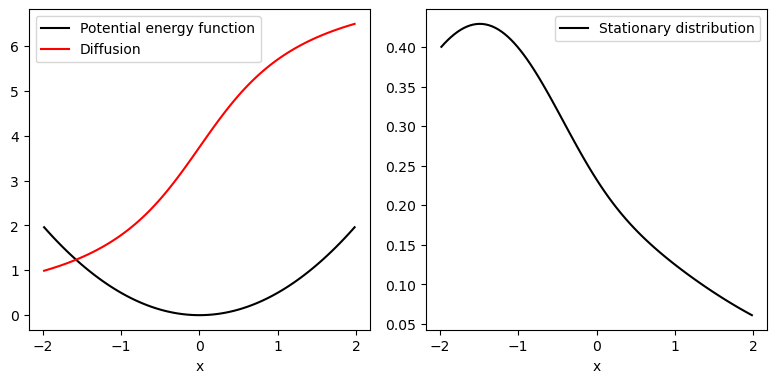

In [22]:
# Grid
xbins     = 100   
xmin      = - 2
xmax      = - xmin
xedges    = np.linspace(xmin, xmax, xbins)  # array with x edges
dx        = xedges[1] - xedges[0]
xcenters  = xedges[:-1] + (dx / 2)                # array with x centers
xbins     = xbins - 1


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20*in2cm, 10*in2cm))  

ax1.plot(xcenters, V(xcenters), 'k-',label='Potential energy function')
ax1.plot(xcenters, D(xcenters), 'r-',label='Diffusion')
ax1.legend()
ax1.set_xlabel('x');

ax2.plot(xcenters, P(xcenters), 'k-',label='Stationary distribution')
ax2.set_xlabel('x');
ax2.legend()

fig.tight_layout()

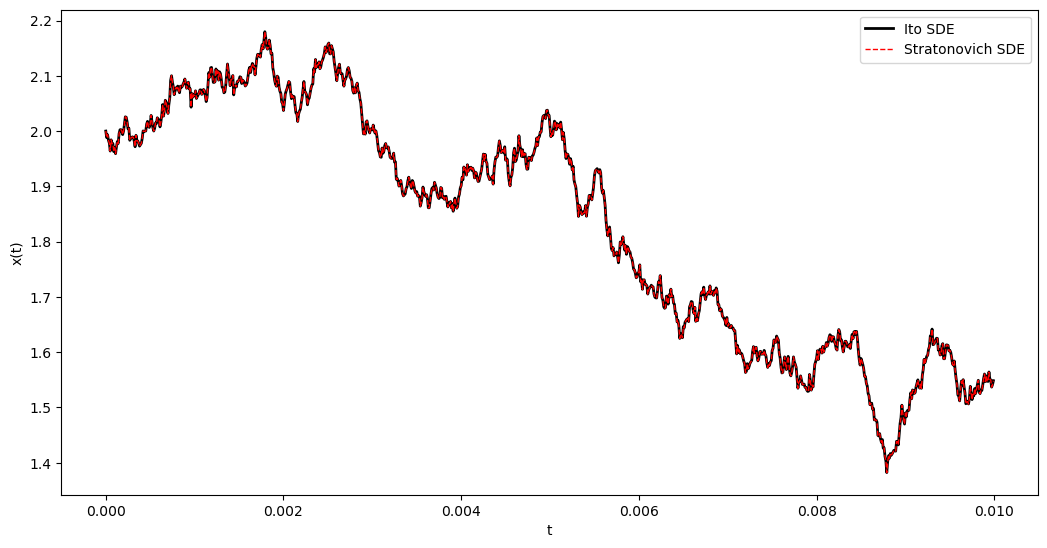

In [26]:
# Integration step
dt  = 0.00001
sdt = np.sqrt(dt)

# Number of steps
N = 1000

# Time intervals
tvalues = np.linspace(0, N-1, N) * dt

x0 = 2

# Euler-Maruyama scheme
x = np.zeros(N)
x[0] = x0

#

# Generate random numbers
eta    = np.random.normal(0,1,N)

for k in range(N-1):
    
    x[k+1] = x[k] + f(x[k]) * dt + sigma(x[k]) * eta[k] * sdt
    
    
# Heun scheme
y = np.zeros(N)
y[0] = x0

for k in range(N-1):

    tilde_y = y[k] + f(y[k]) * dt - 0.5 * der_sigma(y[k]) * sigma(y[k]) *dt + sigma(y[k]) * eta[k] * sdt
    
    y[k+1]  = y[k] + f(y[k]) * dt - 0.5 * der_sigma(y[k]) * sigma(y[k]) * dt + sigma(0.5 * (tilde_y + y[k])) * eta[k] * sdt
    

fig, ax = plt.subplots(1, 1,figsize=(32*in2cm, 16*in2cm))  

ax.plot(tvalues, x, 'k', label='Ito SDE', linewidth = 2)
ax.plot(tvalues, y, 'r--', label='Stratonovich SDE', linewidth = 1)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.legend();

In [27]:
# Number of replicas
Nreps = 10000

# Integration step
dt  = 0.001
sdt = np.sqrt(dt)

# Number of steps
Nsteps = 500


# Euler-Maruyama scheme
x = np.zeros((Nsteps, Nreps))

# initial position
x0     = -1
x[0,:] = x0

# Array for histogram
H = np.zeros((Nsteps, xbins))

# Histogram of the first step
h = np.histogram(x[0,:], bins=xbins, range=(xmin, xmax), density=True)
H[0,:]   = h[0]



# Time intervals
tvalues = np.linspace(0, Nsteps-1, Nsteps) * dt



# Generate random numbers
eta    = np.random.normal(0,1,(Nsteps, Nreps))

# Generate ensemble of trajectories
for k in range(Nsteps-1):
    
    x[k+1,:]    = x[k,:] + f(x[k,:]) * dt + sigma(x[k,:]) * eta[k,:] * sdt
    
    h           = np.histogram(x[k+1,:], bins=xbins, range=(xmin, xmax), density=True)
    H[k+1,:]    = h[0]

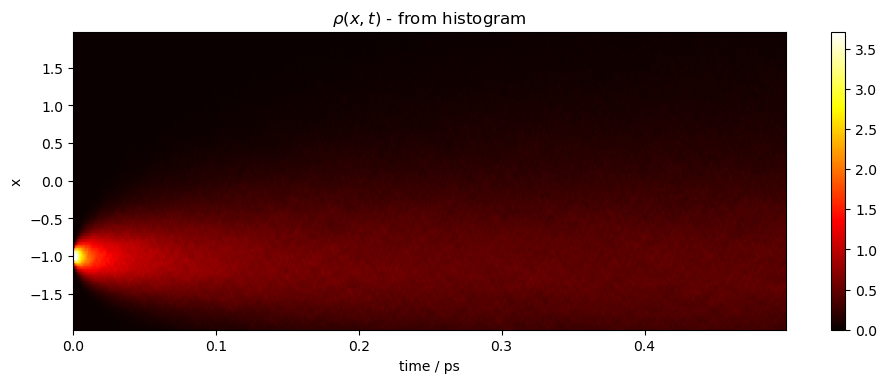

In [25]:
fig, (ax1) = plt.subplots(1, 1, figsize=(25*in2cm, 10*in2cm))

[Tvalues, Xcenters] = np.meshgrid(tvalues, xcenters)

p1 = ax1.pcolormesh(Tvalues, Xcenters, H.T, cmap='hot', vmin = 0, vmax = 0.15*np.max(H), shading='gouraud');
ax1.set_xlabel('time / ps')
ax1.set_ylabel('x')
ax1.set_title(r'$\rho(x,t)$ - from histogram')
fig.colorbar(p1)


fig.tight_layout()